In [ ]:
# ML Model Programming
# Apply PCA on the features and use PCA transformed features for building classfication model using SVM.

   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                177.0                3                low      F   
1                216.0                2                low      M   
2                183.0                4                low      M   
3                176.0                4             medium      M   
4                184.0                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44         1233.0            

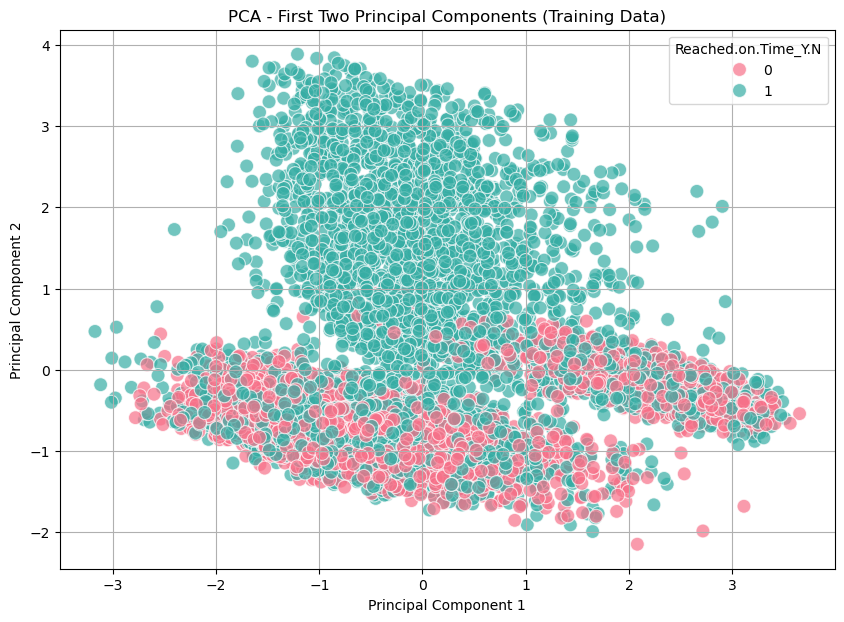

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset
data = pd.read_csv("/Users/diboshbaruah/Desktop/Python/data.csv")

# Inspecting the dataset
print(data.head())
print()

# Inspecting missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)
print()

# Dropping the 'ID' column as it's not a feature used for modeling
data = data.drop(columns=['ID'])

# Imputed missing values
data['Product_importance'] = data['Product_importance'].fillna(data['Product_importance'].mode()[0])
data['Cost_of_the_Product'] = data['Cost_of_the_Product'].fillna(data['Cost_of_the_Product'].mean())
data['Weight_in_gms'] = data['Weight_in_gms'].fillna(data['Weight_in_gms'].mean())

# Encoding categorical variables using LabelEncoder
encoder = LabelEncoder()
categorical_cols = ['Product_importance', 'Warehouse_block', 'Mode_of_Shipment', 'Gender']

for col in categorical_cols:
    data[col] = encoder.fit_transform(data[col])

# Defining features and target variable
X = data.drop(columns=['Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define preprocessing for numerical and categorical features
numeric_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
                    'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

# Imputing numerical features with mean
# Standardizing numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()) 
])

# Imputing categorical features with most frequent value
# One-hot encode categorical features, drop first to avoid multicollinearity
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop='first')) 
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Defining PCA and SVM pipeline
pca = PCA()  # Initialize PCA without specifying components
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
])

# Fitting PCA on training data
X_train_pca = pipeline.fit_transform(X_train)

# Transforming test data
X_test_pca = pipeline.transform(X_test)

# Determining the number of components to keep 95% variance
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_.cumsum()
n_components = (explained_variance <= 0.95).sum() + 1

# Updating PCA to retain components for 95% variance
pipeline.set_params(pca=PCA(n_components=n_components))
X_train_pca = pipeline.fit_transform(X_train)
X_test_pca = pipeline.transform(X_test)

# Training the SVM model
svm = SVC(kernel='rbf')
svm.fit(X_train_pca, y_train)

# Making predictions and evaluate
y_pred = svm.predict(X_test_pca)
print(classification_report(y_test, y_pred))
print()

# Plotting the PCA components for the training data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='husl', s=100, alpha=0.7)
plt.title('PCA - First Two Principal Components (Training Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

